https://marinecadastre.gov/data/

[Office for Coastal Management, 2023: Nationwide Automatic Identification System 2022, https://www.fisheries.noaa.gov/inport/item/67336](https://www.fisheries.noaa.gov/inport/item/67336)

https://coast.noaa.gov/data/marinecadastre/ais/data-dictionary.pdf

### M.1371 : Technical characteristics for an automatic identification system using time division multiple access in the VHF maritime mobile frequency band (Rec. ITU-R M.1371-5 )

https://www.itu.int/rec/R-REC-M.1371-5-201402-I/en

| Identifier No. | Vessel Type                                                  |
| -------------- | ------------------------------------------------------------ |
| 50             | Special craft                                                |
| 51             | Pilot vessel                                                 |
| 52             | Search and rescue vessels                                    |
| 53             | Tugs                                                         |
| 54             | Port tenders                                                 |
| 55             | Vessels with anti-pollution facilities or equipment          |
| 56             | Law enforcement vessels                                      |
| 57             | Spare – for assignments to local vessels                     |
| 58             | Spare – for assignments to local vessels                     |
| 59             | Medical transports (as defined in the 1949 Geneva Conventions and Additional Protocols) |
| 60             | Ships and aircraft of States not parties to an armed conflict |
| 0X             | Fishing vessels                                              |
| 1X             | Carrying dangerous goods (DG), harmful substances (HS), or marine pollutants (MP), or IMO hazard or pollutant category X |
| 2X             | Towing vessels                                               |
| 3X             | Vessels engaged in dredging or underwater operations         |
| 4X             | Vessels engaged in diving operations                         |
| 5X             | Reserved for future use                                      |
| 6X             | Passenger ships                                              |
| 7X             | Cargo ships                                                  |
| 8X             | Tankers                                                      |
| 9X             | Other types of ships                                         |

Table 53: Identifiers to be used by ships to report their type (Rec. ITU-R M.1371-5)

| Navigation Status | Description               |
|-------------------|---------------------------|
| 0                 | Under way using engine    |
| 1                 | At anchor                 |
| 2                 | Not under command         |
| 3                 | Restricted maneuverability|
| 4                 | Constrained by her draught|
| 5                 | Moored                    |
| 6                 | Aground                   |
| 7                 | Engaged in fishing        |
| 8                 | Under way sailing         |

In [0]:
spark.read.table("ais.june").printSchema()

root
 |-- MMSI: string (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- TranscieverClass: string (nullable = true)
 |-- filename: string (nullable = true)



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from scipy import stats

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Filter for vessels with non-null speed values (SOG)
ais_speed_df = ais_june_df.filter(col("SOG").isNotNull())

# Separate the data into Class A and Class B groups
class_a_speeds = ais_speed_df.filter(col("TranscieverClass") == "A").select("SOG").rdd.flatMap(lambda x: x).collect()
class_b_speeds = ais_speed_df.filter(col("TranscieverClass") == "B").select("SOG").rdd.flatMap(lambda x: x).collect()

# Perform independent two-sample t-test
t_statistic, p_value = stats.ttest_ind(class_a_speeds, class_b_speeds, equal_var=False)

# Print the results
print("Independent Two-Sample t-Test Results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

Independent Two-Sample t-Test Results:
t-statistic: 1257.319122705708
p-value: 0.0


The t-statistic is 1257.319 and the p-value is 0.0. The t-statistic measures the magnitude of the difference between the means of the two groups, and a larger absolute t-statistic indicates a larger difference. The p-value represents the probability of observing the given difference (or a more extreme difference) between the two groups if the null hypothesis is true. A smaller p-value indicates stronger evidence against the null hypothesis.

Since the p-value is extremely small (close to zero), we can conclude that there is a significant difference in the average vessel speeds between Class A and Class B transceiver-equipped vessels. The difference is statistically significant, suggesting that the two classes of transceivers are associated with different average speeds.

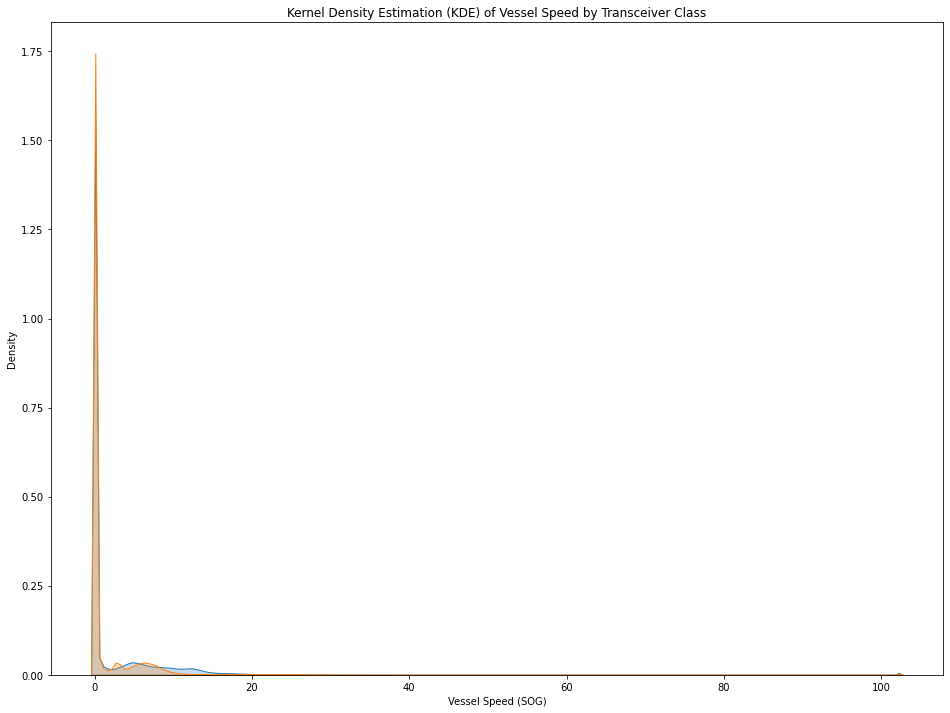

In [0]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Filter for vessels with non-null speed values (SOG)
ais_speed_df = ais_june_df.filter(col("SOG").isNotNull())

# Separate the data into Class A and Class B groups
class_a_speeds = ais_speed_df.filter(col("TranscieverClass") == "A").select("SOG").toPandas()["SOG"]
class_b_speeds = ais_speed_df.filter(col("TranscieverClass") == "B").select("SOG").toPandas()["SOG"]

# Set plot size
plt.figure(figsize=(16, 12))

# Plot KDEs for Class A and Class B speeds using Seaborn
sns.kdeplot(data=class_a_speeds, shade=True, label="Class A")
sns.kdeplot(data=class_b_speeds, shade=True, label="Class B")

# Set plot labels and title
plt.xlabel("Vessel Speed (SOG)")
plt.ylabel("Density")
plt.title("Kernel Density Estimation (KDE) of Vessel Speed by Transceiver Class")

# Show the plot
plt.show()

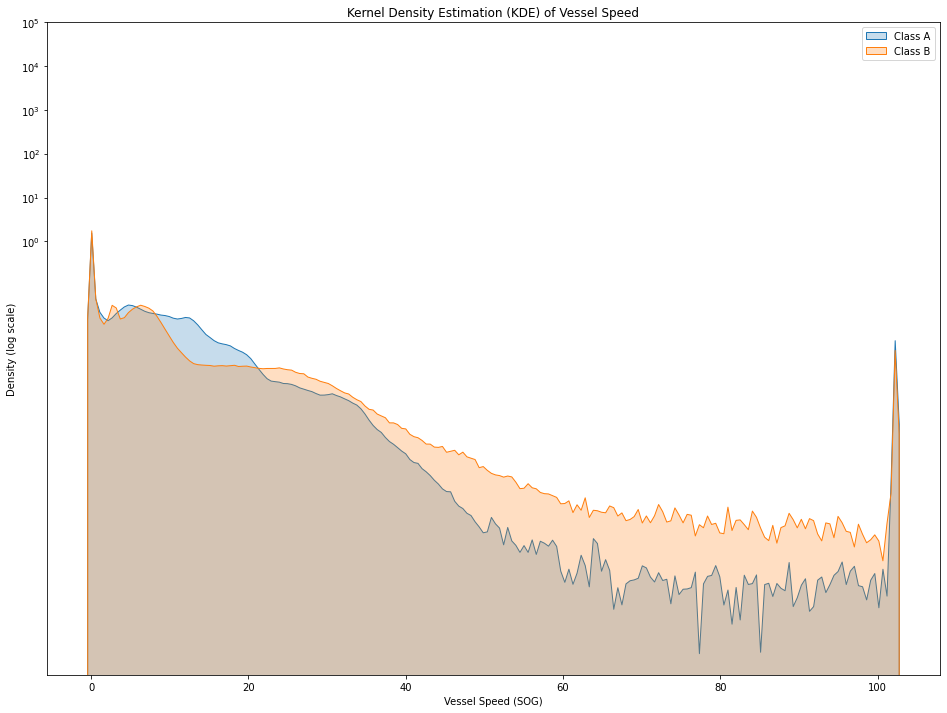

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Filter for vessels with non-null speed values (SOG)
ais_speed_df = ais_june_df.filter(col("SOG").isNotNull())

# Separate the data into Class A and Class B groups
class_a_speeds = ais_speed_df.filter(col("TranscieverClass") == "A").select("SOG").toPandas()["SOG"]
class_b_speeds = ais_speed_df.filter(col("TranscieverClass") == "B").select("SOG").toPandas()["SOG"]

# Set the figure size using figsize
plt.figure(figsize=(16, 12))

# Plot KDEs for Class A and Class B speeds using Seaborn
sns.kdeplot(class_a_speeds, shade=True, label="Class A")
sns.kdeplot(class_b_speeds, shade=True, label="Class B")

# Set y-axis to logarithmic scale
plt.yscale("log")

# Set plot labels and title
plt.xlabel("Vessel Speed (SOG)")
plt.ylabel("Density (log scale)")
plt.title("Kernel Density Estimation (KDE) of Vessel Speed")
plt.legend()

# Adjust y-axis ticks for logarithmic scale
y_ticks = [10**i for i in range(int(plt.ylim()[0]), int(plt.ylim()[1])+1)]
plt.yticks(y_ticks)

# Show the plot
plt.show()

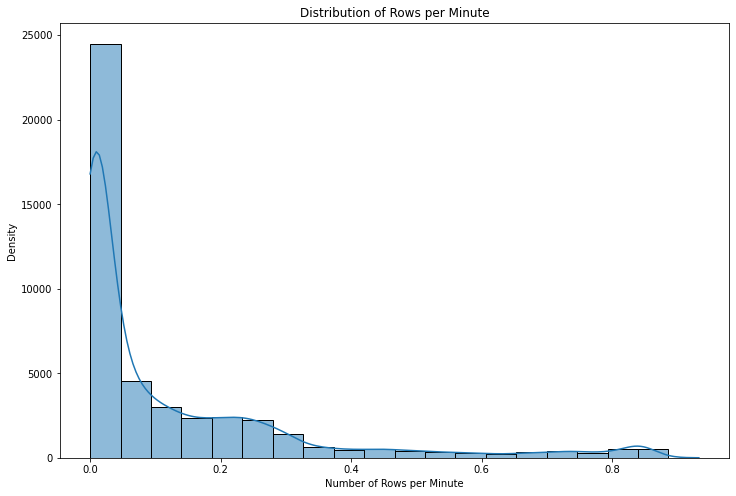

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
import math

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Group by MMSI and calculate the count of rows for each MMSI
mmsi_count_df = ais_june_df.groupBy("MMSI").agg(count("*").alias("RowCount"))

# Calculate the total number of minutes in June 2022
total_minutes = 30 * 24 * 60

# Calculate the "number of rows divided by number of minutes" ratio
mmsi_ratio_df = mmsi_count_df.withColumn("Ratio", expr("RowCount / {}".format(total_minutes)))

# Convert the ratio DataFrame to Pandas for plotting
mmsi_ratio_pd = mmsi_ratio_df.select("Ratio").toPandas()

# Set the figure size using figsize
plt.figure(figsize=(12, 8))

# Plot the distribution using Seaborn
sns.histplot(data=mmsi_ratio_pd, x="Ratio", bins=20, kde=True)

# Set plot labels and title
plt.xlabel("Number of Rows per Minute")
plt.ylabel("Density")
plt.title("Distribution of Rows per Minute")

# Show the plot
plt.show()


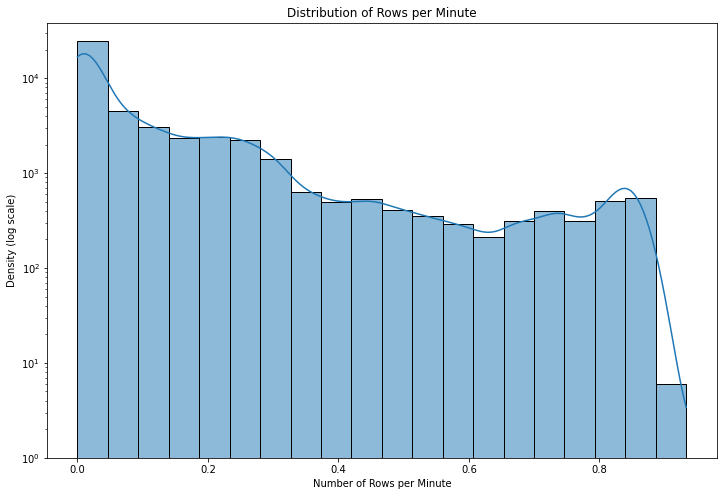

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
import math

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Group by MMSI and calculate the count of rows for each MMSI
mmsi_count_df = ais_june_df.groupBy("MMSI").agg(count("*").alias("RowCount"))

# Calculate the total number of minutes in June 2022
total_minutes = 30 * 24 * 60

# Calculate the "number of rows divided by number of minutes" ratio
mmsi_ratio_df = mmsi_count_df.withColumn("Ratio", expr("RowCount / {}".format(total_minutes)))

# Convert the ratio DataFrame to Pandas for plotting
mmsi_ratio_pd = mmsi_ratio_df.select("Ratio").toPandas()

# Set the figure size using figsize
plt.figure(figsize=(12, 8))

# Plot the distribution using Seaborn
sns.histplot(data=mmsi_ratio_pd, x="Ratio", bins=20, kde=True)

# Set y-axis to logarithmic scale
plt.yscale("log")

# Set plot labels and title
plt.xlabel("Number of Rows per Minute")
plt.ylabel("Density (log scale)")
plt.title("Distribution of Rows per Minute")

# Adjust y-axis ticks for logarithmic scale
y_ticks = [10**i for i in range(int(math.log10(plt.ylim()[0])), int(math.log10(plt.ylim()[1]))+1)]
plt.yticks(y_ticks)

# Show the plot
plt.show()

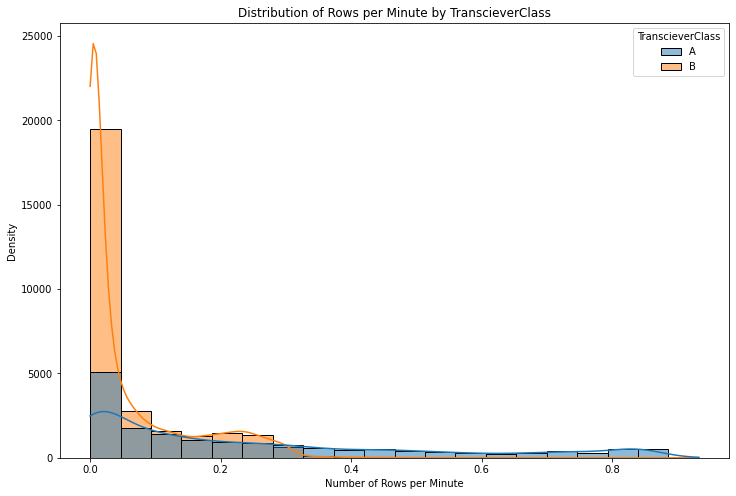

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Group by MMSI and TranscieverClass and calculate the count of rows for each combination
mmsi_count_df = ais_june_df.groupBy("MMSI", "TranscieverClass").agg(count("*").alias("RowCount"))

# Calculate the total number of minutes in June 2022
total_minutes = 30 * 24 * 60

# Calculate the "number of rows divided by number of minutes" ratio
mmsi_ratio_df = mmsi_count_df.withColumn("Ratio", expr("RowCount / {}".format(total_minutes)))

# Convert the ratio DataFrame to Pandas for plotting
mmsi_ratio_pd = mmsi_ratio_df.toPandas()

# Set the figure size using figsize
plt.figure(figsize=(12, 8))

# Plot the distribution using Seaborn with separate curves for TranscieverClass values 'A' and 'B'
sns.histplot(data=mmsi_ratio_pd, x="Ratio", hue="TranscieverClass", bins=20, kde=True)

# Set plot labels and title
plt.xlabel("Number of Rows per Minute")
plt.ylabel("Density")
plt.title("Distribution of Rows per Minute by TranscieverClass")

# Show the plot
plt.show()


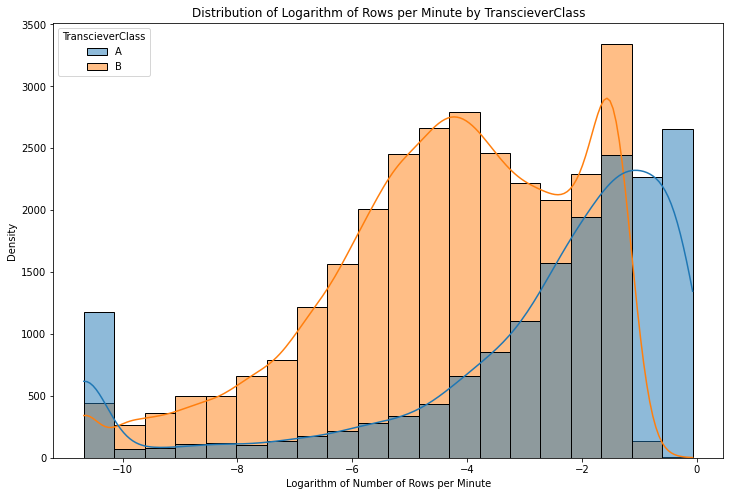

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
import math

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Group by MMSI and TranscieverClass and calculate the count of rows for each combination
mmsi_count_df = ais_june_df.groupBy("MMSI", "TranscieverClass").agg(count("*").alias("RowCount"))

# Calculate the total number of minutes in June 2022
total_minutes = 30 * 24 * 60

# Calculate the "number of rows divided by number of minutes" ratio
mmsi_ratio_df = mmsi_count_df.withColumn("Ratio", expr("RowCount / {}".format(total_minutes)))

# Apply logarithm transformation to the ratio column
mmsi_ratio_df = mmsi_ratio_df.withColumn("LogRatio", expr("log(Ratio)"))

# Convert the ratio DataFrame to Pandas for plotting
mmsi_ratio_pd = mmsi_ratio_df.toPandas()

# Set the figure size using figsize
plt.figure(figsize=(12, 8))

# Plot the distribution using Seaborn with separate curves for TranscieverClass values 'A' and 'B'
sns.histplot(data=mmsi_ratio_pd, x="LogRatio", hue="TranscieverClass", bins=20, kde=True)

# Set plot labels and title
plt.xlabel("Logarithm of Number of Rows per Minute")
plt.ylabel("Density")
plt.title("Distribution of Logarithm of Rows per Minute by TranscieverClass")

# Show the plot
plt.show()

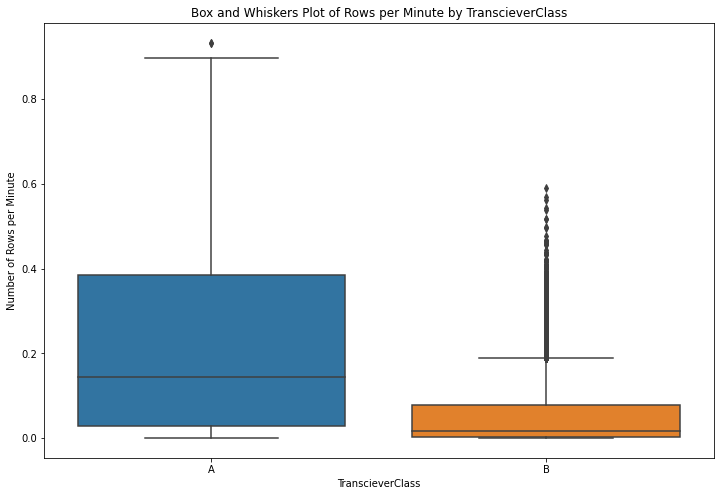

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
import math

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Group by MMSI and TranscieverClass and calculate the count of rows for each combination
mmsi_count_df = ais_june_df.groupBy("MMSI", "TranscieverClass").agg(count("*").alias("RowCount"))

# Calculate the total number of minutes in June 2022
total_minutes = 30 * 24 * 60

# Calculate the "number of rows divided by number of minutes" ratio
mmsi_ratio_df = mmsi_count_df.withColumn("Ratio", expr("RowCount / {}".format(total_minutes)))

# Convert the ratio DataFrame to Pandas for plotting
mmsi_ratio_pd = mmsi_ratio_df.toPandas()

# Set the figure size using figsize
plt.figure(figsize=(12, 8))

# Create a box and whiskers plot using Seaborn with separate boxes for TranscieverClass values 'A' and 'B'
sns.boxplot(data=mmsi_ratio_pd, x="TranscieverClass", y="Ratio")

# Set plot labels and title
plt.xlabel("TranscieverClass")
plt.ylabel("Number of Rows per Minute")
plt.title("Box and Whiskers Plot of Rows per Minute by TranscieverClass")

# Show the plot
plt.show()


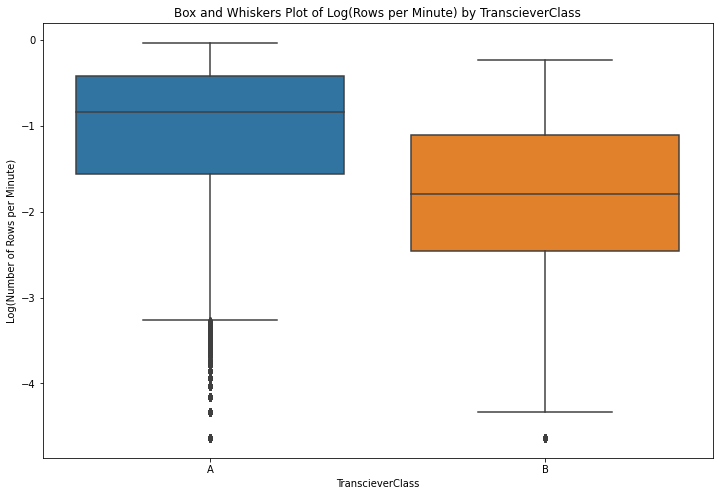

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, expr
import math
import numpy as np

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the AIS June table into a DataFrame
ais_june_df = spark.read.table("ais.june")

# Group by MMSI and TranscieverClass and calculate the count of rows for each combination
mmsi_count_df = ais_june_df.groupBy("MMSI", "TranscieverClass").agg(count("*").alias("RowCount"))

# Calculate the total number of minutes in June 2022
total_minutes = 30 * 24 * 60

# Calculate the "number of rows divided by number of minutes" ratio
mmsi_ratio_df = mmsi_count_df.withColumn("Ratio", expr("RowCount / {}".format(total_minutes)))

# Convert the ratio DataFrame to Pandas for plotting
mmsi_ratio_pd = mmsi_ratio_df.toPandas()

# Apply logarithmic transformation to the Ratio values
mmsi_ratio_pd["Ratio"] = np.log10(mmsi_ratio_pd["Ratio"])

# Set the figure size using figsize
plt.figure(figsize=(12, 8))

# Create a box and whiskers plot with logarithmic y-axis
sns.boxplot(data=mmsi_ratio_pd, x="TranscieverClass", y="Ratio")

# Set plot labels and title
plt.xlabel("TranscieverClass")
plt.ylabel("Log(Number of Rows per Minute)")
plt.title("Box and Whiskers Plot of Log(Rows per Minute) by TranscieverClass")

# Show the plot
plt.show()


In [0]:
%sql
SELECT COUNT(*) FROM ais.june WHERE TranscieverClass = 'A';

count(1)
176491134


In [0]:
%sql
SELECT COUNT(*) FROM ais.june WHERE TranscieverClass = 'B';

count(1)
72834978
